In [1]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt


## Cargo el dataset

In [2]:
# Load data from https://www.openml.org/d/554
X_all, Y_all = fetch_openml('mnist_784', version=1, return_X_y=True)

# lo convierto a int
Y_all = Y_all.astype(int)
X_all = X_all.astype(int)

# X_all.shape, Y_all.shape
%whos ndarray


Variable   Type       Data/Info
-------------------------------
X_all      ndarray    70000x784: 54880000 elems, type `int64`, 439040000 bytes (418.701171875 Mb)
Y_all      ndarray    70000: 70000 elems, type `int64`, 560000 bytes (546.875 kb)


## Muestro alguna imagen

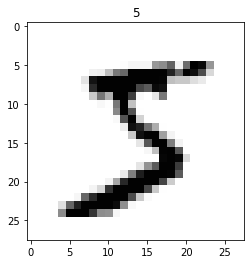

In [3]:
i_img = 0
img = X_all[i_img]
lbl = Y_all[i_img]

img = img.reshape(28, 28)

plt.imshow(img, cmap="Greys");
plt.title("{}".format(lbl));


## Creo un dataset para detección de un número en particular

[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]


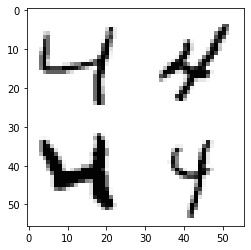

In [4]:
num_det = 4 # entre el 0 y el 9
Y_all2 = Y_all.copy()
X_all2 = X_all.copy()

# pongo un 1 donde está el número y un 0 sino
Y_all2[Y_all == num_det] = 1
Y_all2[Y_all != num_det] = 0

print(Y_all2[:100])

# visualizo algunas muestras

xtemp = X_all2[Y_all2 == 1][:4]

img_mont = np.bmat([[xtemp[0].reshape(28,28),
          xtemp[1].reshape(28,28),], 
         [xtemp[2].reshape(28,28),
          xtemp[3].reshape(28,28),]
        ])
plt.imshow(img_mont, cmap="Greys");



### Selecciono dataset de train y de test

In [5]:
limit = 1000
X = X_all2[:limit]
Y = Y_all2[:limit]

tlimit = 500 # nro training
tlimit2 = 100 # nro testing
X_train, Y_train = X[:tlimit], Y[:tlimit]
X_test, Y_test = X[tlimit:tlimit+tlimit2], Y[tlimit:tlimit+tlimit2]

print("# train = {}, # test = {} ".format( len(X_train), len(X_test))  )
print(len(np.unique(Y_train)))
print(np.unique(Y_train))
print(np.unique(Y_test))

# train = 500, # test = 100 
2
[0 1]
[0 1]


## Computo PCA

In [6]:
alpha = 13
pca = PCA(n_components=alpha).fit(X_train)
Xtc_train = pca.transform(X_train)
Xtc_test = pca.transform(X_test)

X_train.shape, Xtc_train.shape, X_test.shape, Xtc_test.shape


((500, 784), (500, 13), (100, 784), (100, 13))

## Computo kNN

In [7]:
K = 5
clf = knn(n_neighbors=K, p=2)
clf.fit(Xtc_train, Y_train);

# ?knn

## Analizo el resultado

In [8]:
preds = clf.predict(Xtc_test)
ok = preds == Y_test
# preds.shape, Y_test.shape
err = sum(ok) / len(ok)
print("Deteccion del nro {} con {} de accuracy".format(num_det,err))

np.vstack((preds[10:25],Y_test[10:25],ok[10:25])).T


Deteccion del nro 4 con 0.97 de accuracy


array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

### tp, tn, fp y fn

In [9]:
tp = np.sum( np.logical_and(preds == 1, Y_test == 1) )
tn = np.sum( np.logical_and(preds == 0, Y_test == 0) )
fp = np.sum( np.logical_and(preds == 1, Y_test == 0) )
fn = np.sum( np.logical_and(preds == 0, Y_test == 1) )

tp, tn, fp, fn

(5, 92, 1, 2)

### Métricas de error

In [10]:
acc = (tp + tn) / (tp+tn+fp+fn)
prec = tp / (tp + fp)
rec = tp / (tp + fn)

print("Acc = {:.2f}  Prec = {:.2f}  Rec = {:.2f}".format(acc, prec, rec))

Acc = 0.97  Prec = 0.83  Rec = 0.71


In [11]:
def metricas(preds, Y_test):
    tp = np.sum( np.logical_and(preds == 1, Y_test == 1) )
    tn = np.sum( np.logical_and(preds == 0, Y_test == 0) )
    fp = np.sum( np.logical_and(preds == 1, Y_test == 0) )
    fn = np.sum( np.logical_and(preds == 0, Y_test == 1) )
    acc = (tp + tn) / (tp+tn+fp+fn)
    if (tp + fp) == 0:
        prec = 0
    else:
        prec = tp / (tp + fp)
    if (tp + fn) == 0:
        rec = 0
    else:
        rec = tp / (tp + fn)
    return acc, prec, rec

## Analizo la variación de las métricas en funcion de k

In [12]:
import sys

K_vals = np.arange(1,40,2)
mets = np.zeros((len(K_vals), 3))
               
for i,k in enumerate(K_vals):
    clf = knn(n_neighbors=k, p=2)
    clf.fit(Xtc_train, Y_train)
    preds = clf.predict(Xtc_test)
    acc, prec, rec = metricas(preds, Y_test)
    mets[i] = [acc,prec,rec]
    
# mets

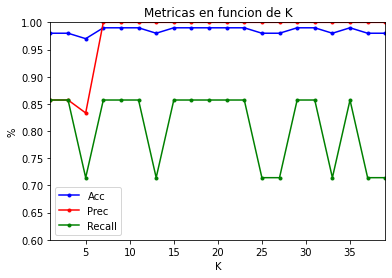

In [13]:
plt.plot(K_vals,mets[:,0], 'b.-')
plt.plot(K_vals,mets[:,1], 'r.-')
plt.plot(K_vals,mets[:,2], 'g.-')
plt.title("Metricas en funcion de K")
plt.xlabel("K")
plt.ylabel("%")
plt.axis([1, K_vals[-1], 0.6, 1])
plt.gca().legend(('Acc','Prec','Recall'))




## Analizo la variación de las métricas en funcion de alpha para K fijo

In [14]:
alphas = np.arange(1,20,2)
K_vals_fixes = np.array([1,3,15])

dmets = { i : np.zeros((len(alphas), 3)) for i in K_vals_fixes}
dmets

{1: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 3: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 15: array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])}

In [15]:
for i,a in enumerate(alphas):
    
    pca = PCA(n_components=a).fit(X_train)
    Xtc_train = pca.transform(X_train)
    Xtc_test = pca.transform(X_test)

    for j,k in enumerate(K_vals_fixes):
        clf = knn(n_neighbors=k, p=2)
        clf.fit(Xtc_train, Y_train)
        preds = clf.predict(Xtc_test)
        acc, prec, rec = metricas(preds, Y_test)
        mets = dmets[k]
        mets[i] = [acc,prec,rec]


dmets

{1: array([[0.81      , 0.        , 0.        ],
        [0.92      , 0.44444444, 0.57142857],
        [0.91      , 0.4       , 0.57142857],
        [0.95      , 0.625     , 0.71428571],
        [0.95      , 0.66666667, 0.57142857],
        [0.98      , 0.85714286, 0.85714286],
        [0.98      , 0.85714286, 0.85714286],
        [0.98      , 0.85714286, 0.85714286],
        [0.97      , 0.75      , 0.85714286],
        [0.96      , 0.66666667, 0.85714286]]),
 3: array([[0.87      , 0.        , 0.        ],
        [0.95      , 0.625     , 0.71428571],
        [0.93      , 0.5       , 0.71428571],
        [0.95      , 0.625     , 0.71428571],
        [0.96      , 0.71428571, 0.71428571],
        [0.98      , 0.85714286, 0.85714286],
        [0.98      , 0.85714286, 0.85714286],
        [0.96      , 0.66666667, 0.85714286],
        [0.97      , 0.75      , 0.85714286],
        [0.98      , 0.85714286, 0.85714286]]),
 15: array([[0.93      , 0.        , 0.        ],
        [0.94      ,

## Metricas para PCA

/home/fpousa/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/home/fpousa/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/fpousa/.virtualenvs/metodos/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecation

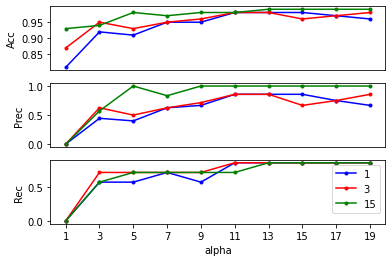

In [16]:
line_styles = ['b.-', 'r.-', 'g.-', 'k.-', 'y.-', 'm.-']
for j,k in enumerate(K_vals_fixes):
    mets = dmets[k]

    plt.subplot(3, 1, 1)
    plt.plot(alphas,mets[:,0], line_styles[j])
    plt.ylabel("Acc")
    plt.xticks([])

    plt.subplot(3, 1, 2)
    plt.plot(alphas,mets[:,1], line_styles[j])
    plt.ylabel("Prec")
    plt.xticks([])
    
    plt.subplot(3, 1, 3)
    plt.plot(alphas,mets[:,2], line_styles[j])
    plt.ylabel("Rec")
    plt.xticks([])

    
plt.xlabel("alpha")
plt.xticks(alphas)
# plt.axis([1, alphas[-1], 0.1, 1])
plt.gca().legend([str(i) for i in K_vals_fixes])


# Ahora analizo el comportamiento multiclase

In [17]:
limit = 10000
X = X_all[:limit]
Y = Y_all[:limit]

tlimit = 5000 # nro training
tlimit2 = 1000 # nro testing
X_train, Y_train = X[:tlimit], Y[:tlimit]
X_test, Y_test = X[tlimit:tlimit+tlimit2], Y[tlimit:tlimit+tlimit2]

print("# train = {}, # test = {} ".format( len(X_train), len(X_test))  )

alpha = 25
pca = PCA(n_components=alpha).fit(X_train)
Xtc_train = pca.transform(X_train)
Xtc_test = pca.transform(X_test)

X_train.shape, Xtc_train.shape, X_test.shape, Xtc_test.shape

K = 1
clf = knn(n_neighbors=K, p=2)
clf.fit(Xtc_train, Y_train);

preds = clf.predict(Xtc_test)
ok = preds == Y_test
preds.shape, Y_test.shape
err = sum(ok) / len(ok)
print("Accuracy = {}".format(err))


# train = 5000, # test = 1000 
Accuracy = 0.948


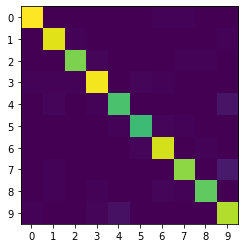

In [18]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(Y_test,preds)

plt.imshow(cm)
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10));

Confusion matrix, without normalization


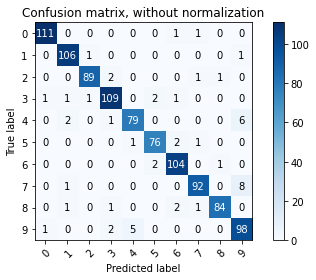

In [19]:
from plot_confusion_matrix import *

classes =  np.array([0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(Y_test, preds, classes, normalize=False);
